In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import chi2_contingency
import geocoder
import statistics

In [2]:
%reload_kedro

2021-04-19 16:45:15,701 - root - INFO - Registered hooks from 2 installed plugin(s): kedro-mlflow-0.7.0
2021-04-19 16:45:15,728 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.


/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/kedro/framework/project/__init__.py:133: UserWarning: Found duplicate pipeline entries. The following will be overwritten: __default__
  warn(


2021-04-19 16:45:15,964 - root - INFO - ** Kedro project viabill
2021-04-19 16:45:15,978 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-04-19 16:45:16,002 - root - INFO - Registered line magic `run_viz`


## Load data


In [3]:
df_cust = catalog.load("customers")
d_sex = {1: 'male', 2:'female', 0: 'other'}
df_cust.sex = df_cust.sex.apply(lambda x: d_sex[x])

df_cust['residentialAddress_clean'] = df_cust.residentialAddress.apply(lambda x: re.sub(r'[0-9]+', '', x))
df_cust['postalAddress_clean']  = df_cust.postalAddress.apply(lambda x: re.sub(r'[0-9]+', '', x) if x==x else '')
df_cust['same_address'] = (df_cust.residentialAddress==df_cust.postalAddress).astype(int)


2021-04-19 16:45:16,052 - kedro.io.data_catalog - INFO - Loading data from `customers` (CSVDataSet)...


In [4]:
df_trans = catalog.load("transactions")
df_trans['late'] = df_trans.filter(regex='payment').apply(lambda x: x==1).any(axis=1).astype(int)
df_trans['default'] = df_trans.filter(regex='payment').apply(lambda x: x==2).any(axis=1).astype(int)

df_trans["defualted_payment"] = df_trans.replace({
    'paymentStatus1': {1: 0, 2: 1},
    'paymentStatus2': {1: 0, 2: 2},
    'paymentStatus3': {1: 0, 2: 3},
    'paymentStatus4': {1: 0, 2: 4},
}).filter(regex='payment').replace({0: np.nan}).min(axis=1).fillna(0)

df_trans["late_payment_first"] = df_trans.replace({
    'paymentStatus1': {1: 1, 2: 0},
    'paymentStatus2': {1: 2, 2: 0},
    'paymentStatus3': {1: 3, 2: 0},
    'paymentStatus4': {1: 4, 2: 0},
}).filter(regex='payment').replace({0: np.nan}).min(axis=1).fillna(0)

2021-04-19 16:45:20,526 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...
2021-04-19 16:45:22,496 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [5]:
df_trans['money_lost'] = df_trans['defualted_payment']/4 * df_trans['price']

In [6]:
print(f"""
Numer of rows in 'customers' table - {df_cust.shape[0]/1000:.0f} K.
Numer of columns in 'customers' table - {df_cust.shape[1]}.

Numer of rows in 'transactions' table - {df_trans.shape[0]/1000000:.0f} M.
Numer of columns in 'transactions' table - {df_trans.shape[1]}.

Numer of uniqe customers in 'customers' table - {len(df_cust.customerID.unique())/1000:.0f} K.
Numer of uniqe customers in 'transactions' table - {len(df_trans.customerID.unique())/1000:.0f} K.
""")


Numer of rows in 'customers' table - 500 K.
Numer of columns in 'customers' table - 9.

Numer of rows in 'transactions' table - 2 M.
Numer of columns in 'transactions' table - 13.

Numer of uniqe customers in 'customers' table - 500 K.
Numer of uniqe customers in 'transactions' table - 491 K.



Check if rows in data in Customer and Transactions tables are not duplicated

In [7]:
if df_cust.customerID.nunique() == df_cust.shape[0]:
    print("Data in Customer table are NOT duplicated.")
else:
    print("Data in Customer table ARE duplicated.")

Data in Customer table are NOT duplicated.


In [8]:
if df_trans.transactionID.nunique() == df_trans.shape[0]:
    print("Data in Transactions table are NOT duplicated.")
else:
    print("Data in Transactions table ARE duplicated.")

Data in Transactions table are NOT duplicated.


## Customers table

In [9]:
df_cust.head()

,customerID,sex,age,residentialAddress,postalAddress,income,residentialAddress_clean,postalAddress_clean,same_address
0,1,male,25,28 Irvine Place,28 Irvine Place,NaN,Irvine Place,Irvine Place,1
1,2,male,19,72 Bertha Street,72 Bertha Street,43200.0,Bertha Street,Bertha Street,1
2,3,female,22,63 Ladberry Street,63 Ladberry Street,70200.0,Ladberry Street,Ladberry Street,1
3,4,other,24,98 Linneman Close,98 Linneman Close,93900.0,Linneman Close,Linneman Close,1
4,5,male,53,56 Salonica Road,56 Salonica Road,77000.0,Salonica Road,Salonica Road,1


In [10]:
print("Nulls percentage:")
(df_cust.replace('',np.nan).isna().sum()/ df_cust.shape[0]).map(lambda x:'{:.2f}%'.format(x*100))

Nulls percentage:


customerID                  0.00%
sex                         0.00%
age                         0.00%
residentialAddress          0.00%
postalAddress               2.02%
income                      1.99%
residentialAddress_clean    0.00%
postalAddress_clean         2.02%
same_address                0.00%
dtype: object

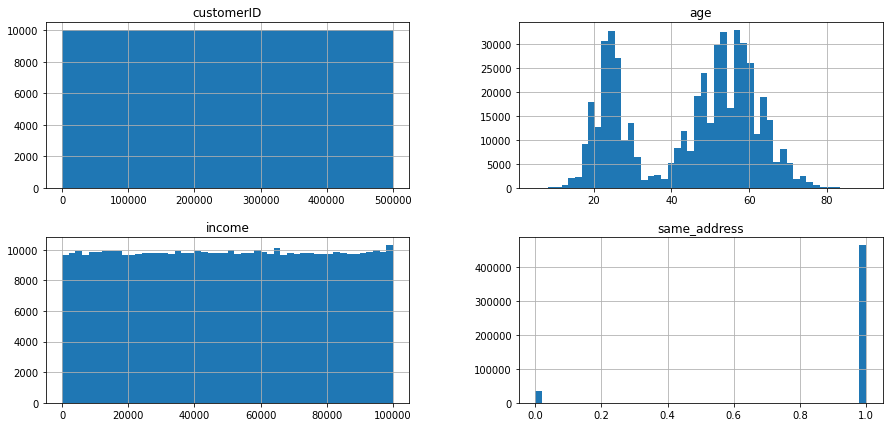

In [11]:
%matplotlib inline
df_cust.hist(bins=50, figsize=(15,7)) 
plt.show()

### sex vs age

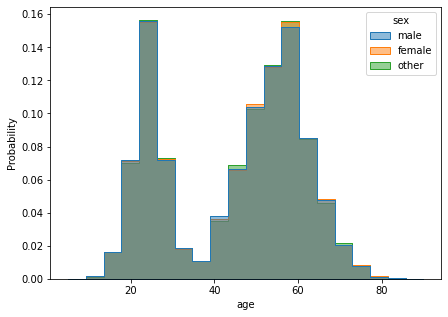

In [12]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(df_cust, x="age", hue="sex", ax=ax, alpha=0.5, bins=20, element="step", stat="probability", common_norm=False)
plt.show()

In [13]:
_tmp = pd.crosstab(df_cust.sex, pd.cut(df_cust.age, 7), rownames=['sex'], colnames=['age'])
_tmp.style.background_gradient(cmap ='Blues',axis=1)


age,"(4.915, 17.143]","(17.143, 29.286]","(29.286, 41.429]","(41.429, 53.571]","(53.571, 65.714]","(65.714, 77.857]","(77.857, 90.0]"
sex,,,,,,,
female,1778,28840,5806,25381,32238,6095,190
male,6574,108134,22081,94778,119441,22950,587
other,438,7246,1408,6409,8053,1532,41


In [14]:
# Tests whether two categorical variables are related or independent.
# assumptions:
# * Observations used in the calculation of the contingency table are independent.
# 25 or more examples in each cell of the contingency table.
#H0: the two samples are independent.
#H1: there is a dependency between the samples.

# Example of the Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=12.594, p=0.399
Probably independent


### sex vs income

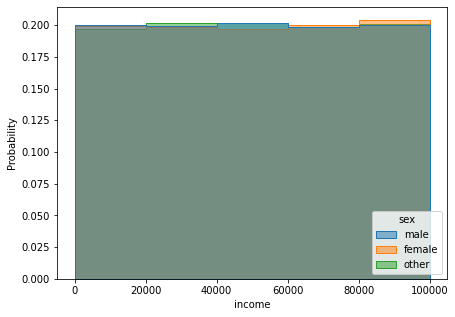

In [15]:
%matplotlib inline

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
fig, ax = plt.subplots(figsize=(7,5))
g = sns.histplot(df_cust, x="income", hue="sex", ax=ax, alpha=0.5, bins=5, 
             element="step", stat="probability", common_norm=False)

move_legend(ax, 4)


In [16]:
_tmp = pd.crosstab(df_cust.sex, pd.cut(df_cust.income, 5), rownames=['sex'], colnames=['income'])
_tmp.style.background_gradient(cmap ='Blues',axis=1)

income,"(-100.0, 20000.0]","(20000.0, 40000.0]","(40000.0, 60000.0]","(60000.0, 80000.0]","(80000.0, 100000.0]"
sex,,,,,
female,19683,19591,19400,19731,19976
male,73967,73099,73852,73061,73017
other,4879,4978,4964,4900,4927


In [17]:
# Example of the Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=16.843, p=0.032
Probably dependent


Highlights:
* there are two customer segments, given age: ~25 years, ~55 years, 
* there's no dependency between age and sex,
* there may be dependency between sex and income, 

### age vs income

In [18]:
from pandas.plotting import scatter_matrix

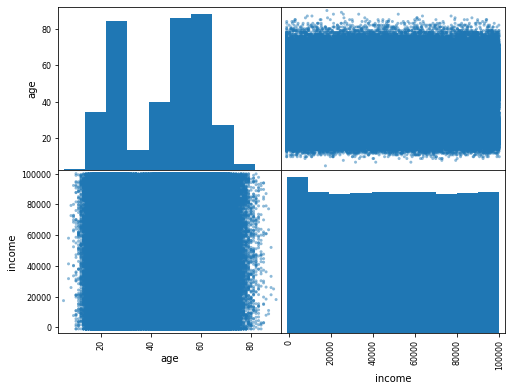

In [19]:
%matplotlib inline
attributes = ['age','income']
scatter_matrix(df_cust[attributes].fillna(-999), figsize=(8, 6))
plt.show()

In [20]:
_tmp = pd.crosstab(pd.cut(df_cust.fillna(-999).income, 7), pd.cut(df_cust.age, 7), rownames=['income'], colnames=['age'])
_tmp.style.background_gradient(cmap ='Blues',axis=1)

age,"(4.915, 17.143]","(17.143, 29.286]","(29.286, 41.429]","(41.429, 53.571]","(53.571, 65.714]","(65.714, 77.857]","(77.857, 90.0]"
income,,,,,,,
"(-1099.999, 13429.429]",1324,21957,4434,19351,24249,4669,120
"(13429.429, 27857.857]",1244,20311,4188,17871,22293,4348,113
"(27857.857, 42286.286]",1238,20360,4114,17930,22551,4312,110
"(42286.286, 56714.714]",1203,20784,4091,17650,22829,4332,125
"(56714.714, 71143.143]",1258,20409,4162,17753,22666,4231,121
"(71143.143, 85571.571]",1273,19978,4100,17859,22549,4275,121
"(85571.571, 100000.0]",1250,20421,4206,18154,22595,4410,108


In [21]:
# Example of the Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=34.090, p=0.560
Probably independent


# Transactions table

Look for outliers

In [22]:
df_trans.describe().T.style.format({'mean': '{:.2f}'})

,count,mean,std,min,25%,50%,75%,max
transactionID,2000000.000000,1000000.50,577350.413527,1.000000,500000.750000,1000000.500000,1500000.250000,2000000.000000
shopID,2000000.000000,549.25,259.847443,100.000000,324.000000,549.000000,774.000000,999.000000
customerID,1979983.000000,250095.15,144288.944851,1.000000,125139.000000,250096.000000,375093.000000,500000.000000
price,2000000.000000,101.53,57.175753,3.000000,52.000000,102.000000,151.000000,200.000000
paymentStatus1,2000000.000000,0.12,0.360735,0.000000,0.000000,0.000000,0.000000,2.000000
paymentStatus2,2000000.000000,0.15,0.427886,0.000000,0.000000,0.000000,0.000000,2.000000
paymentStatus3,2000000.000000,0.19,0.505364,0.000000,0.000000,0.000000,0.000000,2.000000
paymentStatus4,2000000.000000,0.27,0.616858,0.000000,0.000000,0.000000,0.000000,2.000000
late,2000000.000000,0.29,0.455622,0.000000,0.000000,0.000000,1.000000,1.000000
default,2000000.000000,0.09,0.289078,0.000000,0.000000,0.000000,0.000000,1.000000


25% of customers are late with second payment    
max price is `$200`, average price is `$102`
 

In [23]:
print("Nulls percentage:")
(df_trans.replace('',np.nan).isna().sum()/ df_trans.shape[0]).map(lambda x:'{:.2f}%'.format(x*100))

Nulls percentage:


transactionID         0.00%
shopID                0.00%
customerID            1.00%
price                 0.00%
paymentStatus1        0.00%
paymentStatus2        0.00%
paymentStatus3        0.00%
paymentStatus4        0.00%
late                  0.00%
default               0.00%
defualted_payment     0.00%
late_payment_first    0.00%
money_lost            0.00%
dtype: object

There are some transacions withou customer ID.   
Lets have a look at it

In [24]:
_tmp = pd.concat([
    df_trans.describe().T[['mean']].reset_index(drop=False),
    df_trans.query("customerID != customerID").describe().T[['mean']].reset_index(drop=True)
], axis=1)
_tmp.columns=['column','all-mean','noCustId-mean']
_tmp.style.format({'all-mean': '{:.2f}','noCustId-mean': '{:.2f}'})

,column,all-mean,noCustId-mean
0,transactionID,1000000.50,994726.03
1,shopID,549.25,551.78
2,customerID,250095.15,nan
3,price,101.53,102.37
4,paymentStatus1,0.12,0.12
5,paymentStatus2,0.15,0.15
6,paymentStatus3,0.19,0.18
7,paymentStatus4,0.27,0.27
8,late,0.29,0.29
9,default,0.09,0.09


there is almost no difference in data distribution, it makes no harm 

## Shops

In [25]:
df_trans.head()

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,defualted_payment,late_payment_first,money_lost
0,1,114,2869.0,140,0,0,0,0,0,0,0.0,0.0,0.0
1,2,855,124077.0,70,0,0,0,0,0,0,0.0,0.0,0.0
2,3,752,86184.0,85,0,0,0,0,0,0,0.0,0.0,0.0
3,4,246,248861.0,43,1,0,0,0,1,0,0.0,1.0,0.0
4,5,973,162112.0,127,0,0,0,0,0,0,0.0,0.0,0.0


In [26]:
pd.DataFrame(df_trans.shopID.value_counts().values, columns=['Number of transactions in Shops']).describe()

,Number of transactions in Shops
count,900.000000
mean,2222.222222
std,46.310741
min,2087.000000
25%,2192.000000
50%,2223.000000
75%,2253.000000
max,2379.000000


array([[<AxesSubplot:title={'center':'Number of transactions in Shops'}>]],
      dtype=object)

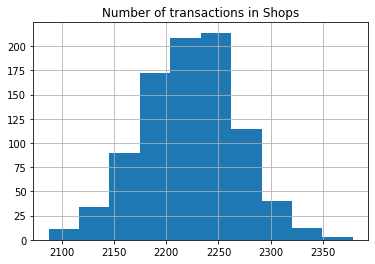

In [27]:
pd.DataFrame(df_trans.shopID.value_counts().values, columns=['Number of transactions in Shops']).hist()

<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

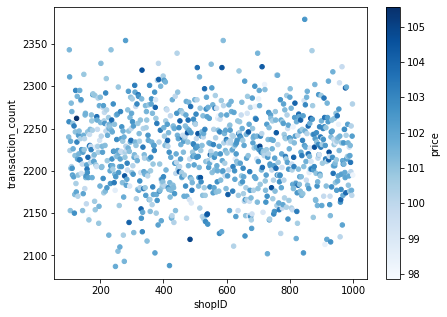

In [28]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    price=('price', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'price', kind='scatter',colormap="Blues", ax=ax)

Number of transactions and average price are almost the same for all shops.

<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

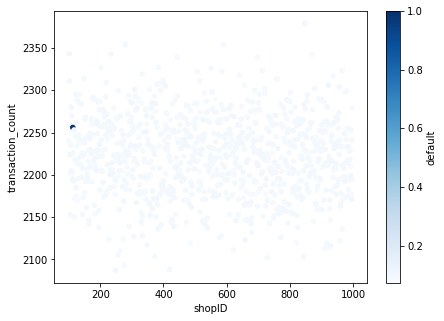

In [29]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    default=('default', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'default', kind='scatter',colormap="Blues", ax=ax)

There is one shop that seems to be fraud.

In [30]:
df_trans.groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    default=('default', 'mean')
).sort_values(by='default').tail(5)

,transaction_count,default
shopID,,
190,2260,0.107080
623,2269,0.107096
658,2123,0.107866
450,2199,0.108686
113,2256,1.000000


Instalments from shop "113" are never paid back- it either corrupted data or fraud.    
I will indicate this shop initially as fraud and will be omitting in further analysis.    


In [31]:
df_trans.loc[df_trans.shopID == 113]

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,defualted_payment,late_payment_first,money_lost
1701,1702,113,9169.0,9,2,2,2,2,0,1,1.0,1.0,2.25
2530,2531,113,325418.0,122,2,2,2,2,0,1,1.0,1.0,30.50
3567,3568,113,457004.0,123,2,2,2,2,0,1,1.0,1.0,30.75
4577,4578,113,93714.0,70,2,2,2,2,0,1,1.0,1.0,17.50
4723,4724,113,177400.0,96,2,2,2,2,0,1,1.0,1.0,24.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995352,1995353,113,337672.0,80,2,2,2,2,0,1,1.0,1.0,20.00
1996060,1996061,113,120027.0,180,2,2,2,2,0,1,1.0,1.0,45.00
1998490,1998491,113,287125.0,34,2,2,2,2,0,1,1.0,1.0,8.50
1998904,1998905,113,419778.0,180,2,2,2,2,0,1,1.0,1.0,45.00


In [32]:
df_trans['fraud'] = 0
df_trans.loc[df_trans.shopID == 113,'fraud'] = 1

### shops without fraudulent one

<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

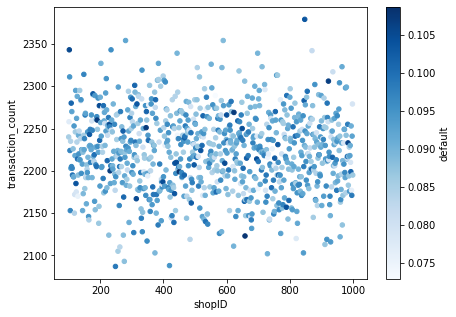

In [33]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    default=('default', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'default', kind='scatter',colormap="Blues", ax=ax)


In [34]:
df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    defualted_payment=('defualted_payment', 'mean')
).reset_index().sort_values('defualted_payment')

,shopID,transaction_count,defualted_payment
463,564,2289,0.211883
252,353,2278,0.216418
629,730,2216,0.216606
598,699,2179,0.217531
1,101,2258,0.219221
...,...,...,...
883,984,2233,0.330945
821,922,2306,0.331310
562,663,2215,0.331828
349,450,2199,0.332879


<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

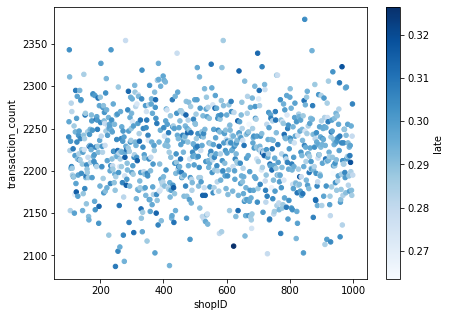

In [35]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    late=('late', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'late', kind='scatter',colormap="Blues", ax=ax)

### transaction table - customerID

In [36]:
df_trans

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,defualted_payment,late_payment_first,money_lost,fraud
0,1,114,2869.0,140,0,0,0,0,0,0,0.0,0.0,0.0,0
1,2,855,124077.0,70,0,0,0,0,0,0,0.0,0.0,0.0,0
2,3,752,86184.0,85,0,0,0,0,0,0,0.0,0.0,0.0,0
3,4,246,248861.0,43,1,0,0,0,1,0,0.0,1.0,0.0,0
4,5,973,162112.0,127,0,0,0,0,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999996,758,333312.0,12,0,0,1,1,1,0,0.0,3.0,0.0,0
1999996,1999997,932,31802.0,145,0,2,2,2,0,1,2.0,2.0,72.5,0
1999997,1999998,932,449391.0,19,0,0,0,0,0,0,0.0,0.0,0.0,0
1999998,1999999,878,433902.0,198,0,1,0,0,1,0,0.0,2.0,0.0,0


In [37]:
_tmp = df_trans.groupby("customerID").agg(
    transaction_count=('transactionID', 'count'),
    price=('price', 'mean'),
    late=('late', 'mean'),
    late_payment_first = ('late_payment_first', 'mean'),
    default=('default', 'mean'),
    defualted_payment=('defualted_payment', 'mean'),
    money_lost=('money_lost', 'sum')
).reset_index()

In [38]:
_tmp.describe()

,customerID,transaction_count,price,late,late_payment_first,default,defualted_payment,money_lost
count,490533.000000,490533.000000,490533.000000,490533.000000,490533.000000,490533.000000,490533.000000,490533.000000
mean,249973.179978,4.036391,101.538044,0.294494,0.901574,0.091845,0.274886,28.238682
std,144332.983398,1.927140,32.957038,0.294082,0.841424,0.185714,0.583178,63.619696
min,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,124989.000000,3.000000,80.600000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,249977.000000,4.000000,101.500000,0.250000,0.800000,0.000000,0.000000,0.000000
75%,374973.000000,5.000000,122.500000,0.500000,1.400000,0.142857,0.285714,14.250000
max,500000.000000,16.000000,200.000000,1.000000,4.000000,1.000000,4.000000,970.000000


average lost on client is ~`$28`.  



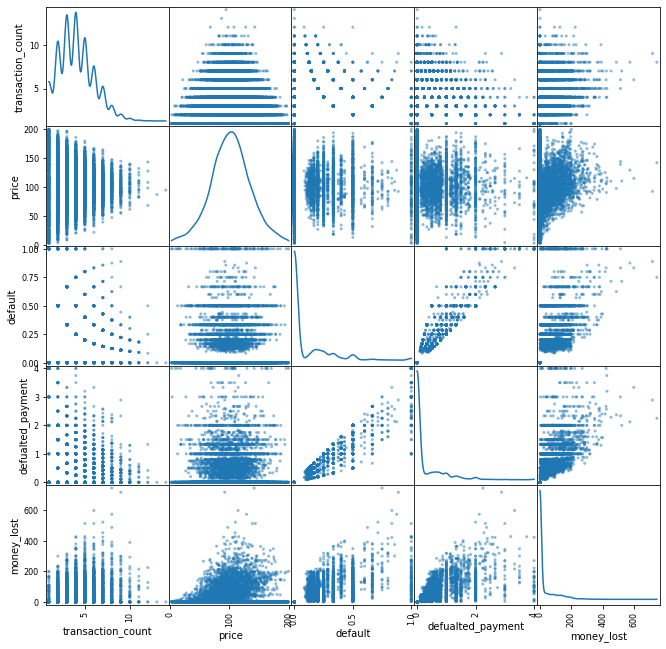

In [39]:
%matplotlib inline
attributes = ['transaction_count','price','default','defualted_payment','money_lost']
scatter_matrix(_tmp[attributes].sample(10000, random_state=1), figsize=(11, 11), diagonal='kde')
plt.show()

<AxesSubplot:xlabel='transaction_count'>

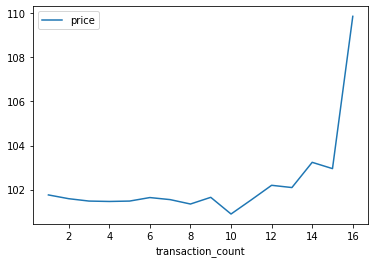

In [40]:
_tmp.groupby('transaction_count').agg(price=('price', 'mean')).plot()

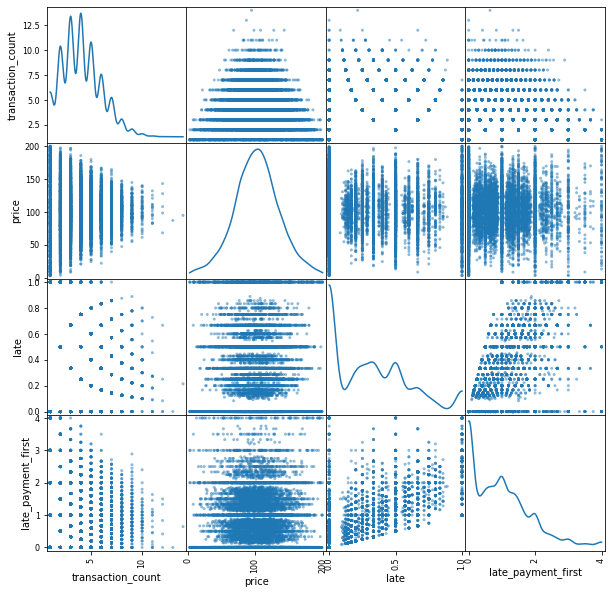

In [41]:
%matplotlib inline
attributes = ['transaction_count','price','late','late_payment_first']
scatter_matrix(_tmp[attributes].sample(10000, random_state=1), figsize=(10, 10), diagonal='kde')
plt.show()

### Default rate, late payments

In [42]:
    late=('late', 'mean'),
    late_payment_first = ('late_payment_first', 'mean'),
    default=('default', 'mean'),
    defualted_payment=('defualted_payment', 'mean'),
    

In [43]:
_tmp = df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    price=('price', 'mean'),
    late=('late', 'mean'),
    default=('default', 'mean'),
    defualted_payment=('defualted_payment', 'mean'),
    money_lost=('money_lost', 'sum')
).reset_index()
_tmp.describe()

,shopID,transaction_count,price,late,default,defualted_payment,money_lost
count,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000
mean,549.985539,2222.184650,101.529381,0.294394,0.091015,0.274566,15506.116518
std,259.687968,46.322792,1.228684,0.009453,0.006199,0.020652,1310.049416
min,100.000000,2087.000000,97.857409,0.263541,0.072958,0.211883,11584.750000
25%,325.500000,2192.000000,100.716603,0.287597,0.087015,0.260724,14606.625000
50%,550.000000,2223.000000,101.510975,0.294742,0.091150,0.274833,15455.000000
75%,774.500000,2253.000000,102.306196,0.301154,0.095195,0.288432,16382.500000
max,999.000000,2379.000000,105.557029,0.326386,0.108686,0.339823,20457.000000


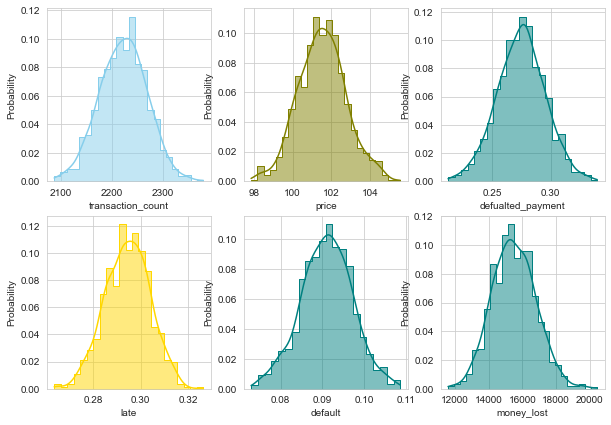

In [44]:
%matplotlib inline

sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 3, figsize=(10, 7))

sns.histplot(data=_tmp, x="transaction_count", kde=True, color="skyblue", ax=axs[0, 0], element="step", stat="probability")
sns.histplot(data=_tmp.astype(np.float32), x="price", kde=True, color="olive", ax=axs[0, 1], element="step", stat="probability")
sns.histplot(data=_tmp, x="late", kde=True, color="gold", ax=axs[1, 0], element="step", stat="probability")
sns.histplot(data=_tmp, x="default", kde=True, color="teal", ax=axs[1, 1], element="step", stat="probability")
sns.histplot(data=_tmp, x="defualted_payment", kde=True, color="teal", ax=axs[0, 2], element="step", stat="probability")
sns.histplot(data=_tmp, x="money_lost", kde=True, color="teal", ax=axs[1, 2], element="step", stat="probability")

plt.show()

## Default and late payment on one transactions

### Late

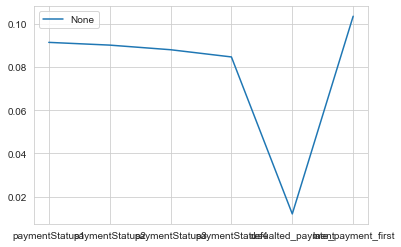

In [45]:
# late
_tmp = (df_trans.query("fraud==0").filter(regex='payment') == 1).astype(int)
_tmp.mean(axis=0).plot()
plt.legend() 
plt.show()

### Default

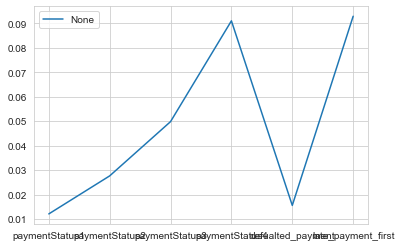

In [46]:
# default
_tmp = (df_trans.query("fraud==0").filter(regex='payment') == 2).astype(int)
_tmp.mean(axis=0).plot()
plt.legend() 
plt.show()

In [47]:
df_trans.query("fraud==0").query("paymentStatus1>1").head()

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,defualted_payment,late_payment_first,money_lost,fraud
91,92,449,455927.0,96,2,2,2,2,0,1,1.0,1.0,24.00,0
136,137,796,447255.0,114,2,2,2,2,0,1,1.0,1.0,28.50,0
304,305,192,393571.0,192,2,2,2,2,0,1,1.0,1.0,48.00,0
323,324,608,378840.0,118,2,2,2,2,0,1,1.0,1.0,29.50,0
430,431,102,236139.0,89,2,2,2,2,0,1,1.0,1.0,22.25,0


### Transaction payment instalments

### First late, next late

In [48]:
def check_dependency(x_0, x_1, name='paymentStatus1', test=False):
    if test:
        table = [x_0,x_1]
    else:
        table = [list(x_0.sum()),list(x_1.sum())]
    stat, p, dof, expected = chi2_contingency(table)
    print(table)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably independent')
    else:
        print('Probably dependent')
    if test:
        return None
    return x_0.mean().to_frame(name=f'{name}_0').join(x_1.mean().to_frame(name=f'{name}_1'))

In [49]:
_tmp_f0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==0].filter(regex='paymentStatus[2-4]').apply(lambda x: x==1).astype(int)
_tmp_f1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==1].filter(regex='paymentStatus[2-4]').apply(lambda x: x==1).astype(int)

check_dependency(_tmp_f0, _tmp_f1).style.background_gradient(cmap ='Blues',axis=1)

[[157382, 153374, 147757], [22530, 22275, 21235]]
stat=2.167, p=0.338
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus2,0.087864,0.123492
paymentStatus3,0.085627,0.122094
paymentStatus4,0.082491,0.116394


### First late, next default

In [50]:
_tmp_f0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==0].filter(regex='paymentStatus[2-4]').apply(lambda x: x==2).astype(int)
_tmp_f1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==1].filter(regex='paymentStatus[2-4]').apply(lambda x: x==2).astype(int)

check_dependency(_tmp_f0, _tmp_f1).style.background_gradient(cmap ='Blues',axis=1)

[[28201, 68647, 143732], [2857, 6739, 13974]]
stat=3.685, p=0.158
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus2,0.015744,0.015660
paymentStatus3,0.038325,0.036938
paymentStatus4,0.080244,0.076595


### Second late, next late

In [51]:
_tmp_s0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==0].filter(regex='paymentStatus[3-4]').apply(lambda x: x==1).astype(int)
_tmp_s1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==1].filter(regex='paymentStatus[3-4]').apply(lambda x: x==1).astype(int)

check_dependency(_tmp_s0, _tmp_s1).style.background_gradient(cmap ='Blues',axis=1)

[[153563, 147509], [22086, 21483]]
stat=1.483, p=0.223
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus3,0.087120,0.122760
paymentStatus4,0.083685,0.119408


### Second late, next default

In [52]:
_tmp_s0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==0].filter(regex='paymentStatus[3-4]').apply(lambda x: x==2).astype(int)
_tmp_s1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==1].filter(regex='paymentStatus[3-4]').apply(lambda x: x==2).astype(int)

check_dependency(_tmp_s0, _tmp_s1).style.background_gradient(cmap ='Blues',axis=1)

[[40431, 115478], [3897, 11170]]
stat=0.030, p=0.863
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus3,0.022937,0.021661
paymentStatus4,0.065513,0.062086


## Customers  transactions history

remove transactions connected with fraudulent shop, and withocut customerID

In [53]:
df_trans = df_trans.loc[df_trans.fraud==0].dropna(subset=['customerID']).reset_index(drop=True)

In [54]:
df_trans['rank']=df_trans.groupby("customerID")["transactionID"].rank("dense", ascending=True)

In [55]:
df_trans

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,defualted_payment,late_payment_first,money_lost,fraud,rank
0,1,114,2869.0,140,0,0,0,0,0,0,0.0,0.0,0.0,0,1.0
1,2,855,124077.0,70,0,0,0,0,0,0,0.0,0.0,0.0,0,1.0
2,3,752,86184.0,85,0,0,0,0,0,0,0.0,0.0,0.0,0,1.0
3,4,246,248861.0,43,1,0,0,0,1,0,0.0,1.0,0.0,0,1.0
4,5,973,162112.0,127,0,0,0,0,0,0,0.0,0.0,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977753,1999996,758,333312.0,12,0,0,1,1,1,0,0.0,3.0,0.0,0,4.0
1977754,1999997,932,31802.0,145,0,2,2,2,0,1,2.0,2.0,72.5,0,4.0
1977755,1999998,932,449391.0,19,0,0,0,0,0,0,0.0,0.0,0.0,0,5.0
1977756,1999999,878,433902.0,198,0,1,0,0,1,0,0.0,2.0,0.0,0,7.0


In [56]:
df_trans['default_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['default']]. \
    shift(1).reset_index(drop=True)

df_trans['defualted_payment_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['defualted_payment']]. \
    shift(1).reset_index(drop=True)

df_trans['money_lost_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['money_lost']]. \
    shift(1).reset_index(drop=True)

df_trans['late_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['late']]. \
    shift(1).reset_index(drop=True)

df_trans['price_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['price']]. \
    shift(1).reset_index(drop=True)

df_trans['late_payment_first_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['late_payment_first']]. \
    shift(1).reset_index(drop=True)


In [57]:
df_trans.sort_values(['customerID','rank']).head()

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,...,late_payment_first,money_lost,fraud,rank,default_lag1,defualted_payment_lag1,money_lost_lag1,late_lag1,price_lag1,late_payment_first_lag1
117899,119294,634,1.0,88,0,0,0,0,0,0,...,0.0,0.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
822744,832074,942,1.0,177,1,0,0,0,1,0,...,1.0,0.0,0,2.0,0.0,0.0,0.0,0.0,88.0,0.0
858829,868540,361,1.0,93,0,0,0,0,0,0,...,0.0,0.0,0,3.0,0.0,0.0,0.0,1.0,177.0,1.0
1678935,1697842,248,1.0,147,0,0,0,0,0,0,...,0.0,0.0,0,4.0,0.0,0.0,0.0,0.0,93.0,0.0
972463,983409,741,2.0,71,1,0,0,0,1,0,...,1.0,0.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


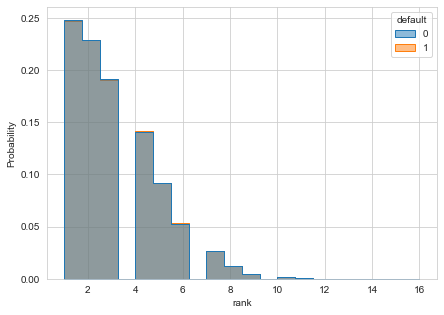

In [58]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(df_trans, x="rank", hue="default", ax=ax, alpha=0.5, bins=20, element="step", stat="probability", common_norm=False)
plt.show()

In [59]:
import time
start_time = time.time()

parameters = dict()
parameters["trans_back_aggreg_list"] = [6]

aggreate_list = df_trans.filter(regex="lag").columns.to_list()

results = []
for i in parameters["trans_back_aggreg_list"]:
    
    print(f"starting aggregation for #{i} transactions back")

    names_sum = [f'{k}_lst_{str(i).zfill(2)}_sum' for k in list(map(lambda x: x.replace('_lag1',''), aggreate_list))]
    names_avg = [f'{k}_lst_{str(i).zfill(2)}_avg' for k in list(map(lambda x: x.replace('_lag1',''), aggreate_list))]

    if len(results) == 0 or len(parameters["trans_back_aggreg_list"]) <= 1:
        results += [pd.concat([
            df_trans.set_index('rank').groupby('customerID')[aggreate_list].rolling(i, min_periods=1).sum().reset_index(),
            df_trans.set_index('rank').groupby('customerID')[aggreate_list].rolling(i, min_periods=1).mean().reset_index().iloc[:, 2:]
            ], axis=1)]

        results[-1].columns = ['customerID', 'rank']+names_sum+names_avg
    else:
        results += [pd.concat([
            df_trans.set_index('rank').groupby('customerID')[aggreate_list].rolling(i, min_periods=1).sum().reset_index().iloc[:, 2:],
            df_trans.set_index('rank').groupby('customerID')[aggreate_list].rolling(i, min_periods=1).mean().reset_index().iloc[:, 2:]
            ], axis=1)]

        results[-1].columns = names_sum+names_avg
    print("--- %s seconds ---" % (time.time() - start_time))


defaults = pd.concat(results, axis=1)



starting aggregation for #6 transactions back
--- 432.0459167957306 seconds ---


In [60]:
defaults

,customerID,rank,default_lst_06_sum,defualted_payment_lst_06_sum,money_lost_lst_06_sum,late_lst_06_sum,price_lst_06_sum,late_payment_first_lst_06_sum,default_lst_06_avg,defualted_payment_lst_06_avg,money_lost_lst_06_avg,late_lst_06_avg,price_lst_06_avg,late_payment_first_lst_06_avg
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.000000,88.000000,0.000000
2,1.0,3.0,0.0,0.0,0.0,1.0,265.0,1.0,0.0,0.0,0.0,0.500000,132.500000,0.500000
3,1.0,4.0,0.0,0.0,0.0,1.0,358.0,1.0,0.0,0.0,0.0,0.333333,119.333333,0.333333
4,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977753,499999.0,4.0,0.0,0.0,0.0,0.0,381.0,0.0,0.0,0.0,0.0,0.000000,127.000000,0.000000
1977754,499999.0,5.0,0.0,0.0,0.0,0.0,523.0,0.0,0.0,0.0,0.0,0.000000,130.750000,0.000000
1977755,499999.0,6.0,0.0,0.0,0.0,0.0,664.0,0.0,0.0,0.0,0.0,0.000000,132.800000,0.000000
1977756,500000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
defaults = pd.concat(results, axis=1)

In [62]:
defaults

,customerID,rank,default_lst_06_sum,defualted_payment_lst_06_sum,money_lost_lst_06_sum,late_lst_06_sum,price_lst_06_sum,late_payment_first_lst_06_sum,default_lst_06_avg,defualted_payment_lst_06_avg,money_lost_lst_06_avg,late_lst_06_avg,price_lst_06_avg,late_payment_first_lst_06_avg
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.000000,88.000000,0.000000
2,1.0,3.0,0.0,0.0,0.0,1.0,265.0,1.0,0.0,0.0,0.0,0.500000,132.500000,0.500000
3,1.0,4.0,0.0,0.0,0.0,1.0,358.0,1.0,0.0,0.0,0.0,0.333333,119.333333,0.333333
4,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977753,499999.0,4.0,0.0,0.0,0.0,0.0,381.0,0.0,0.0,0.0,0.0,0.000000,127.000000,0.000000
1977754,499999.0,5.0,0.0,0.0,0.0,0.0,523.0,0.0,0.0,0.0,0.0,0.000000,130.750000,0.000000
1977755,499999.0,6.0,0.0,0.0,0.0,0.0,664.0,0.0,0.0,0.0,0.0,0.000000,132.800000,0.000000
1977756,500000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df_trans_all = df_trans.merge(defaults, on=['customerID','rank'], how='left')

# Create an Observation for modeling - LAST TRANSACTION

In [64]:
df_trans['rank_reverse'] = df_trans.groupby("customerID")["transactionID"].rank("dense", ascending=False)

In [65]:
df_trans_newest = df_trans.loc[df_trans.rank_reverse==1].reset_index(drop=True)
df_trans_history = df_trans.loc[df_trans.rank_reverse>1].reset_index(drop=True)

Prepare some basic aggregation

In [66]:
"""
df_trans_history_aggr = df_trans_history. \
    groupby('customerID'). \
    agg(
        trans_count=('default', 'count'),
        default_sum=('default', 'sum'),
        default_mean=('default', 'mean'),
        late_sum=('late', 'sum'),
        late_mean=('late', 'mean'),
        price_sum=('price', 'sum'),
        price_mean=('price', 'mean'),
).reset_index(drop=False)
"""
df_trans_history_aggr = df_trans_history. \
    groupby('customerID'). \
    agg(
        hist_trans_count=('default', 'count'),
        hist_default_sum=('default', 'sum'),
        hist_default_avg=('default', 'mean'),
        hist_late_sum=('late', 'sum'),
        hist_late_avg=('late', 'mean'),
        hist_price_sum=('price', 'sum'),
        hist_price_avg=('price', 'mean')
    ).reset_index(drop=False)

In [67]:
df_trans_newest = df_trans_newest.merge(df_trans_history_aggr, on='customerID', how='left')

In [68]:
df_trans_newest = df_trans_newest.merge(defaults, on=['customerID','rank'], how='left')

In [69]:
df_cust_trans = df_cust.merge(df_trans_newest, on = ['customerID'], how='left')

drop clients without transactions

In [70]:
df_cust_trans = df_cust_trans.dropna(subset=['default'])

## Clients age, incom, sex vs default

In [71]:
df_cust_trans[['default','income','age']].fillna({'income':-999}).corr()

,default,income,age
default,1.000000,-0.001673,-0.001520
income,-0.001673,1.000000,0.001813
age,-0.001520,0.001813,1.000000


## Check Address

In [72]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [73]:
addres_clusters_data = df_cust_trans.groupby('residentialAddress_clean'). \
    agg(
        trans_count=('default', 'count'),
        default_sum=('default', 'sum'),
        money_lost_sum=('money_lost', 'sum'),
        default_mean=('default', 'mean'),
        late_sum=('late', 'sum'),
        late_mean=('late', 'mean'),
        price_sum=('price', 'sum'),
        price_mean=('price', 'mean'),
).reset_index(drop=False).sort_values('default_mean')
addres_clusters_data

,residentialAddress_clean,trans_count,default_sum,money_lost_sum,default_mean,late_sum,late_mean,price_sum,price_mean
9242,Omeo Grove,28,0.0,0.00,0.000000,9.0,0.321429,2501.0,89.321429
5792,Hester Court,25,0.0,0.00,0.000000,7.0,0.280000,2165.0,86.600000
613,Assynt Street,26,0.0,0.00,0.000000,11.0,0.423077,3149.0,121.115385
5796,Hethorn Street,28,0.0,0.00,0.000000,7.0,0.250000,2998.0,107.071429
3203,Cribb Street,30,0.0,0.00,0.000000,5.0,0.166667,3050.0,101.666667
...,...,...,...,...,...,...,...,...,...
316,Amery Street,27,9.0,423.00,0.333333,5.0,0.185185,2179.0,80.703704
6921,Knapp Street,12,4.0,362.50,0.333333,5.0,0.416667,1268.0,105.666667
11117,Sixteenth Avenue,24,8.0,358.25,0.333333,6.0,0.250000,2238.0,93.250000
9186,Octave Court,17,6.0,640.00,0.352941,5.0,0.294118,1704.0,100.235294


### Try to create a segments of the similar shops

There are many shops and it's hard to look and analyse each one.    
Check if it is possible to create segments of similar shops.   

In [74]:
scaler = MinMaxScaler()
X=scaler.fit_transform(addres_clusters_data.iloc[:,1:])

In [75]:
from sklearn.manifold import TSNE
data_sample_pca_embedded = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(X)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13260 samples in 0.007s...
[t-SNE] Computed neighbors for 13260 samples in 0.913s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13260
[t-SNE] Computed conditional probabilities for sample 2000 / 13260
[t-SNE] Computed conditional probabilities for sample 3000 / 13260
[t-SNE] Computed conditional probabilities for sample 4000 / 13260
[t-SNE] Computed conditional probabilities for sample 5000 / 13260
[t-SNE] Computed conditional probabilities for sample 6000 / 13260
[t-SNE] Computed conditional probabilities for sample 7000 / 13260
[t-SNE] Computed conditional probabilities for sample 8000 / 13260
[t-SNE] Computed conditional probabilities for sample 9000 / 13260
[t-SNE] Computed conditional probabilities for sample 10000 / 13260
[t-SNE] Computed conditional probabilities for sample 11000 / 13260
[t-SNE] Computed conditional probabilities for sample 12000 / 13260
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='x', ylabel='y'>

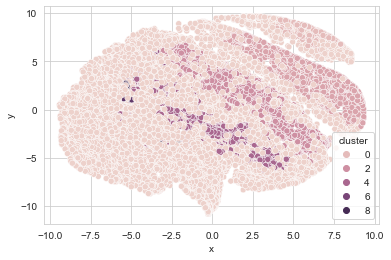

In [76]:

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, IncrementalPCA

clustering = DBSCAN(eps=0.04, min_samples=20).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(data_sample_pca_embedded, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=addres_clusters_data.iloc[:,1:].default_mean)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")



In [77]:
addres_clusters_data['cluster'] = clustering.labels_
addres_clusters_data.groupby('cluster')['default_mean'].mean()

cluster
-1    0.106069
 0    0.000000
 1    0.035543
 2    0.068308
 3    0.077363
 4    0.101078
 5    0.087783
 6    0.096456
 7    0.115645
 8    0.116081
 9    0.124193
Name: default_mean, dtype: float64

In [78]:
df_cust_trans = df_cust_trans.merge(addres_clusters_data[['residentialAddress_clean','cluster']], on='residentialAddress_clean', how='left')


## What country and city

Use openstreetmap api to geocode residentialAddress to get information like: country, city, district/neighbourhood


In [79]:
residentialAddress_geocoded = []
for adr in df_cust_trans.residentialAddress.sample(500, random_state=1).to_list():
    residentialAddress_geocoded += [geocoder.osm(adr.strip()).json]


2021-04-19 16:54:27,644 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=93+Carnoustie+Court&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:54:28,053 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=79+Meadowlands+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:54:28,446 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=7+Windeyer+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:54:30,547 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=19+Forest+Court&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:54:30,927 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=5+Sumners+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:54:31,590 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=86+Horton+Place&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:54:31,934 - geocoder.ba

2021-04-19 16:55:07,408 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=5+Robertson+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:07,897 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=34+Park+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:08,327 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=64+Kingston+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:08,623 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=88+Kiltie+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:09,559 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=63+Princess+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:10,480 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=74+Harrison+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:10,791 - geocoder.bas

2021-04-19 16:55:46,990 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=61+Busby+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:47,412 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=58+Debenham+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:47,883 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=10+Mcdermott+Close&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:48,383 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=7+Gerler+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:49,077 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=18+Miles+platting+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:49,375 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=24+Meecham+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:55:49,902 - geoco

2021-04-19 16:56:18,265 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=3+Douglas+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:18,417 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=70+Northcliffe+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:19,198 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=9+Guildford+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:19,604 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=14+New+cleveland+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:19,943 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=6+Don+young+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:20,681 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=50+Paul+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:20,941 - geocod

2021-04-19 16:56:50,885 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=38+Brevis+Lane&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:51,339 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=24+Trident+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:51,793 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=67+Carowell+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:52,286 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=93+Yantara+Court&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:52,840 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=11+Lemnos+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:53,316 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=6+Mcghie+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:56:53,801 - geocoder.base 

2021-04-19 16:57:24,209 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=7+Deacon+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:24,365 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=90+Grantson+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:25,256 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=76+Bailey+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:25,492 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=41+Brereton+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:26,306 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=76+Dundonald+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:26,959 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=21+Gympie+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:27,123 - geocoder.b

2021-04-19 16:57:55,758 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=42+Calston+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:56,714 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=87+Malvern+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:57,106 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=45+Sunset+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:57,436 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=62+Purser+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:57,861 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=19+Mingera+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:58,394 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=29+Cassowary+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:57:59,203 - geocoder.b

2021-04-19 16:58:30,268 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=73+Grieve+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:58:31,028 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=59+Knapp+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:58:31,417 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=34+Cheel+Place&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:58:31,962 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=4+Isedale+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:58:32,643 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=16+Kennard+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:58:33,116 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=52+Pitt+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:58:33,584 - geocoder.base - INFO

2021-04-19 16:59:01,297 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=89+Drummond+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:01,724 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=97+Gilbert+Road&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:02,008 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=3+Yaldara+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:02,785 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=45+Graham+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:03,004 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=46+Aranui+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:03,509 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=25+Tuleen+Close&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:04,024 - geocoder.base 

2021-04-19 16:59:30,164 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=80+Hibernia+Court&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:30,623 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=95+Normanton+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:31,475 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=58+Eleventh+Avenue&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:31,904 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=42+Bellwood+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:32,269 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=72+Edinglassie+Street&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:32,826 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=13+Rocklily+Court&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:33,275 - 

In [80]:
_tmp = []
for k in residentialAddress_geocoded:
    _tmp += [pd.DataFrame.from_dict([k])]
pd_residentialAddress_geocoded = pd.concat(_tmp)

In [81]:
pd_residentialAddress_geocoded.country.value_counts()

Australia                      274
United States                  125
United Kingdom                  49
New Zealand / Aotearoa          20
Canada                          16
South Africa                     3
Nederland                        3
Deutschland                      3
België / Belgique / Belgien      2
Бългaрия                         1
Viti                             1
عمان                             1
Éire / Ireland                   1
Name: country, dtype: int64

In [82]:
pd_residentialAddress_geocoded.city.value_counts()

Brisbane City    254
London            16
Manchester         5
Sydney             4
Newton             4
                ... 
Johannesburg       1
Jersey City        1
Варна              1
Quinte West        1
Montgomery         1
Name: city, Length: 100, dtype: int64

### Are geo data  real and is there any "risky" neighbourhood?

In [83]:
sample = df_cust_trans.sample(1000, random_state=1)

In [84]:
l_residentialAddress_geocoded = []
for adr in sample.residentialAddress.to_list():
    l_residentialAddress_geocoded += [geocoder.osm(adr.strip()+" ,Brisbane, Australia").json]


2021-04-19 16:59:53,663 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=93+Carnoustie+Court+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:54,150 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=79+Meadowlands+Road+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:54,637 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=7+Windeyer+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:55,343 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=19+Forest+Court+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:55,694 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=5+Sumners+Road+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 16:59:56,247 - geocoder.base - INFO - Requested https://nomi

2021-04-19 17:00:16,563 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=84+Venetia+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:17,219 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=48+Silverdell+Crescent+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:17,611 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=63+Rose+Terrace+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:18,040 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=96+Waller+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:18,560 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=45+Woodfield+Road+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:19,065 - geocoder.base - INFO - Requested https://n

2021-04-19 17:00:39,238 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=18+Wentworth+Court+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:39,631 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=15+Savannah+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:40,287 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=5+Raven+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:40,679 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=32+Oxford+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:41,335 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=95+Solomon+Crescent+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:00:41,607 - geocoder.base - INFO - Requested https://nomin

2021-04-19 17:01:01,650 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=70+Walsall+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:02,307 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=62+Burke+Court+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:02,709 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=64+Smith+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:03,356 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=97+Bilsen+Road+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:03,747 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=35+Balfour+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:04,154 - geocoder.base - INFO - Requested https://nominatim.o

2021-04-19 17:01:24,326 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=18+Jewel+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:24,718 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=57+Panama+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:25,374 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=87+Bond+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:25,662 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=48+Clovelly+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:26,151 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=27+Bunya+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:26,985 - geocoder.base - INFO - Requested https://nominatim.o

2021-04-19 17:01:46,738 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=29+Wylma+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:47,393 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=23+Lawrence+Road+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:47,786 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=13+Chapel+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:48,152 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=54+Mt+d%27aguilar+Crescent+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:48,650 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=7+Clarke+Lane+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:01:49,162 - geocoder.base - INFO - Requested https://no

2021-04-19 17:02:09,155 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=16+Abbotsleigh+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:09,647 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=92+Jillian+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:10,154 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=78+Wongabel+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:10,648 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=58+Kywong+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:11,145 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=21+Beeby+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:11,661 - geocoder.base - INFO - Requested https://no

2021-04-19 17:02:32,025 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=40+Langlo+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:32,875 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=75+Wombat+Crescent+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:33,531 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=60+Old+cleveland+Road+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:33,922 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=77+Hamilton+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:34,332 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=64+Goodenia+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:34,972 - geocoder.base - INFO - Requested https:/

2021-04-19 17:02:55,942 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=59+Knapp+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:56,598 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=34+Cheel+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:56,990 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=4+Isedale+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:57,424 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=16+Kennard+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:57,947 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=52+Pitt+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:02:58,424 - geocoder.base - INFO - Requested https://nominatim.op

2021-04-19 17:03:18,800 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=9+Lensworth+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:19,010 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=35+Albion+Road+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:19,665 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=2+Colston+Road+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:19,960 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=88+Twins+Court+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:20,715 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=86+St+pauls+Terrace+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:20,968 - geocoder.base - INFO - Requested https://nominatim

2021-04-19 17:03:41,063 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=52+Peacock+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:41,686 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=98+Sheena+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:42,078 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=76+Antrim+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:42,734 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=15+Rosella+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:43,125 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=14+Lugg+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:03:43,558 - geocoder.base - INFO - Requested https://nominati

2021-04-19 17:04:03,053 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=85+Woodlark+Crescent+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:03,703 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=78+Solandra+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:04,097 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=66+Goodwood+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:04,751 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=100+Hailey+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:05,145 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=4+Tanglewood+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:05,574 - geocoder.base - INFO - Requested https

2021-04-19 17:04:26,418 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=64+Lowan+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:26,893 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=92+Jirrima+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:27,391 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=14+Brockworth+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:27,935 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=99+Richard+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:28,397 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=8+Rossa+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:28,903 - geocoder.base - INFO - Requested https://nomin

2021-04-19 17:04:49,614 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=97+Strathspey+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:50,233 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=20+Eighth+Avenue+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:50,618 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=43+Scout+Lane+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:51,109 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=38+Mclennan+Close+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:51,614 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=34+Cocoparra+Crescent+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:04:52,109 - geocoder.base - INFO - Requested https://n

2021-04-19 17:05:12,140 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=87+Oswin+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:12,605 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=20+Ramsay+Lane+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:13,112 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=12+Burdock+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:13,688 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=57+Babbidge+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:14,158 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=16+Kittyhawk+Drive+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:14,627 - geocoder.base - INFO - Requested https://nomina

2021-04-19 17:05:34,679 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=78+Aylton+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:35,114 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=43+Kate+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:35,623 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=97+Slobodian+Avenue+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:36,163 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=6+Lange+Court+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:36,613 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=80+Castling+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:37,108 - geocoder.base - INFO - Requested https://nominati

2021-04-19 17:05:57,117 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=51+Niven+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:57,642 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=57+Jeenly+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:58,131 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=58+Flag+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:58,625 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=60+Lichfield+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:59,134 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=80+Polaris+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:05:59,768 - geocoder.base - INFO - Requested https://nominat

2021-04-19 17:06:19,686 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=77+Charles+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:20,114 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=88+Johanne+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:20,623 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=38+Glasshouse+Crescent+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:21,172 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=86+Waratah+Avenue+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:21,623 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=31+Waterbrooke+Circuit+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:22,112 - geocoder.base - INFO - Requested h

2021-04-19 17:06:42,135 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=98+Lugg+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:42,634 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=67+Lone+pine+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:43,112 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=43+Edzell+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:43,609 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=10+Maher+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:44,132 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=84+Kalinga+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:06:44,613 - geocoder.base - INFO - Requested https://nominati

2021-04-19 17:07:04,681 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=23+Callum+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:05,195 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=63+Oxford+Close+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:05,751 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=52+Duncan+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:06,186 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=22+Thornton+Parade+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:06,663 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=75+Gibson+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:07,200 - geocoder.base - INFO - Requested https://nominatim

2021-04-19 17:07:27,208 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=41+Brisbane+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:27,654 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=80+Mahogany+Court+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:28,173 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=3+Macdonald+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:28,660 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=41+Karalee+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:29,220 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=74+Broadleaf+Crescent+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:29,669 - geocoder.base - INFO - Requested https

2021-04-19 17:07:51,689 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=21+Appoline+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:52,288 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=76+Toulon+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:52,698 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=27+Joybelle+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:53,335 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=48+Railway+Terrace+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:53,729 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=10+Old+progress+Road+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:07:54,386 - geocoder.base - INFO - Requested https:

2021-04-19 17:08:15,092 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=21+Robusta+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:08:15,597 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=2+Aquinas+Court+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:08:16,092 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=77+Summerhill+Place+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:08:16,600 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=88+Marzena+Close+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:08:17,181 - geocoder.base - INFO - Requested https://nominatim.openstreetmap.org/search?q=75+York+Street+%2CBrisbane%2C+Australia&format=jsonv2&addressdetails=1&limit=1
2021-04-19 17:08:17,591 - geocoder.base - INFO - Requested https://nominati

In [85]:
_tmp = []
for k in l_residentialAddress_geocoded:
    _tmp += [pd.DataFrame.from_dict([k])]
pd_residentialAddress_geocoded = pd.concat(_tmp)

In [86]:
pd_residentialAddress_geocoded['default_sum'] = sample.default.to_list()

In [87]:
pd_residentialAddress_geocoded['residentialAddress_clean'] = sample.residentialAddress_clean.to_list()

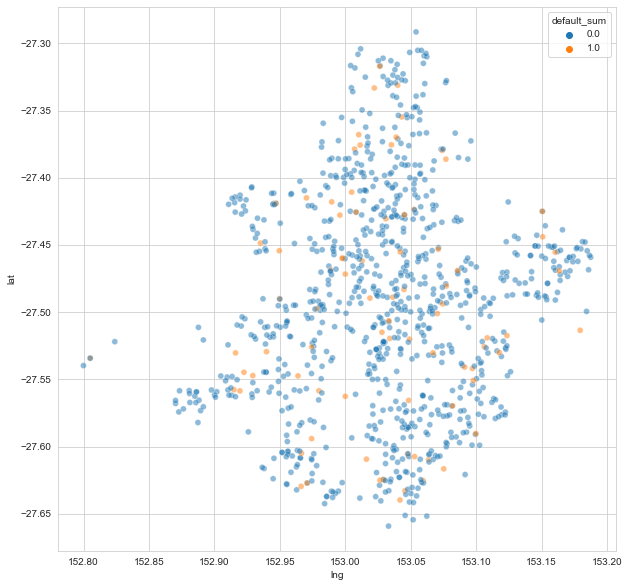

In [88]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=pd_residentialAddress_geocoded, x="lng", y="lat", hue="default_sum", alpha=0.5, ax=ax)
plt.show()

In [89]:
pd_residentialAddress_geocoded.groupby('suburb').agg(
    trans_count=('default_sum', 'count'),
    uniqe_addreses=('residentialAddress_clean', 'nunique'),
    default_sum=('default_sum', 'sum')).reset_index().\
assign(dr = lambda x: x['default_sum'] / x['trans_count']).sort_values('dr', ascending=False).head(10)


,suburb,trans_count,uniqe_addreses,default_sum,dr
120,Pinjarra Hills,1,1,1.0,1.0
97,Middle Park,1,1,1.0,1.0
31,Chandler,2,2,1.0,0.5
119,Petrie Terrace,2,2,1.0,0.5
77,Jindalee,2,2,1.0,0.5
129,Rocklea,2,2,1.0,0.5
71,Highgate Hill,2,2,1.0,0.5
134,Seventeen Mile Rocks,2,2,1.0,0.5
144,Stretton,4,4,2.0,0.5
2,Alderley,2,2,1.0,0.5


In [90]:
pd_residentialAddress_geocoded.groupby(['suburb','residentialAddress_clean']).agg(
    trans_count=('default_sum', 'count'),
    default=('default_sum', 'mean')).reset_index().sort_values('default').query("suburb=='Stretton'")



,suburb,residentialAddress_clean,trans_count,default
731,Stretton,Birchwood Place,1,0.0
732,Stretton,Compton Road,1,0.0
733,Stretton,Oxford Place,1,1.0
734,Stretton,The parkway,1,1.0


### Analyse if postalAddress is the same as residentialAddress

In [91]:
df_cust_trans.groupby('same_address')['default'].mean()

same_address
0    0.312876
1    0.074382
Name: default, dtype: float64

Default rate is significantly bigger when postalAddress is different then residentialAddress

## Create  "geo risk rating"

rate addreses based on average risk 

In [92]:
df_cust_trans.columns

Index(['customerID', 'sex', 'age', 'residentialAddress', 'postalAddress',
       'income', 'residentialAddress_clean', 'postalAddress_clean',
       'same_address', 'transactionID', 'shopID', 'price', 'paymentStatus1',
       'paymentStatus2', 'paymentStatus3', 'paymentStatus4', 'late', 'default',
       'defualted_payment', 'late_payment_first', 'money_lost', 'fraud',
       'rank', 'default_lag1', 'defualted_payment_lag1', 'money_lost_lag1',
       'late_lag1', 'price_lag1', 'late_payment_first_lag1', 'rank_reverse',
       'hist_trans_count', 'hist_default_sum', 'hist_default_avg',
       'hist_late_sum', 'hist_late_avg', 'hist_price_sum', 'hist_price_avg',
       'default_lst_06_sum', 'defualted_payment_lst_06_sum',
       'money_lost_lst_06_sum', 'late_lst_06_sum', 'price_lst_06_sum',
       'late_payment_first_lst_06_sum', 'default_lst_06_avg',
       'defualted_payment_lst_06_avg', 'money_lost_lst_06_avg',
       'late_lst_06_avg', 'price_lst_06_avg', 'late_payment_first_lst_06_

In [93]:
_tmp = df_cust_trans.groupby('residentialAddress_clean')[['hist_default_sum','hist_trans_count']]. \
    sum().reset_index().assign(dr = lambda x: x['hist_default_sum']/x['hist_trans_count'])

<AxesSubplot:>

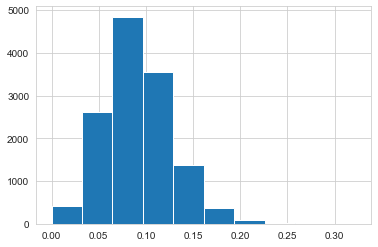

In [94]:
_tmp.dr.hist()

In [95]:
np.quantile(_tmp.dr, [i/10 for i in list(range(1,10,2))], axis=0)

array([0.04860437, 0.07142857, 0.08834466, 0.10666667, 0.1372549 ])

In [96]:
bins = [-np.inf, 0.049, 0.071, 0.088, 0.107, 0.137, np.inf]

In [97]:
geo_risk_rank = df_cust_trans.groupby('residentialAddress_clean')[['hist_default_sum','hist_trans_count']]. \
    sum().reset_index().assign(geo_risk_rank = lambda x: pd.cut(x['hist_default_sum']/x['hist_trans_count'], bins).cat.codes)


In [98]:
df_cust_trans = df_cust_trans.merge(geo_risk_rank[['residentialAddress_clean','geo_risk_rank']], on='residentialAddress_clean', how='left')

In [99]:
df_cust_trans

,customerID,sex,age,residentialAddress,postalAddress,income,residentialAddress_clean,postalAddress_clean,same_address,transactionID,...,price_lst_06_sum,late_payment_first_lst_06_sum,default_lst_06_avg,defualted_payment_lst_06_avg,money_lost_lst_06_avg,late_lst_06_avg,price_lst_06_avg,late_payment_first_lst_06_avg,cluster,geo_risk_rank
0,1,male,25,28 Irvine Place,28 Irvine Place,NaN,Irvine Place,Irvine Place,1,1697842.0,...,358.0,1.0,0.000000,0.000000,0.00,0.333333,119.333333,0.333333,1,4
1,2,male,19,72 Bertha Street,72 Bertha Street,43200.0,Bertha Street,Bertha Street,1,1834257.0,...,599.0,2.0,0.000000,0.000000,0.00,0.333333,99.833333,0.333333,2,2
2,3,female,22,63 Ladberry Street,63 Ladberry Street,70200.0,Ladberry Street,Ladberry Street,1,1974624.0,...,577.0,2.0,0.166667,0.333333,5.50,0.000000,96.166667,0.333333,-1,1
3,4,other,24,98 Linneman Close,98 Linneman Close,93900.0,Linneman Close,Linneman Close,1,1536291.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3
4,5,male,53,56 Salonica Road,56 Salonica Road,77000.0,Salonica Road,Salonica Road,1,661121.0,...,289.0,10.0,0.500000,1.750000,24.25,0.500000,72.250000,2.500000,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490491,499996,male,68,95 Argyle Parade,95 Argyle Parade,40500.0,Argyle Parade,Argyle Parade,1,665043.0,...,173.0,0.0,0.000000,0.000000,0.00,0.000000,173.000000,0.000000,-1,4
490492,499997,female,22,34 Bearke Place,34 Bearke Place,44900.0,Bearke Place,Bearke Place,1,1756533.0,...,181.0,0.0,0.000000,0.000000,0.00,0.000000,90.500000,0.000000,-1,2
490493,499998,male,27,95 Glenhurst Street,95 Glenhurst Street,48700.0,Glenhurst Street,Glenhurst Street,1,1628579.0,...,354.0,0.0,0.000000,0.000000,0.00,0.000000,88.500000,0.000000,4,0
490494,499999,male,55,34 Kiandra Close,34 Kiandra Close,7600.0,Kiandra Close,Kiandra Close,1,1722718.0,...,664.0,0.0,0.000000,0.000000,0.00,0.000000,132.800000,0.000000,-1,1


# Model - initial model only to get intuition about model features

In [100]:
categorical_cols = ['sex', 'residentialAddress_clean','postalAddress_clean',
                    'geo_risk_rank', 'shopID',
                    'same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df_cust_trans.filter(regex='(^hist_)|(_lst_)').columns.to_list()

target_def = 'default'
target_late = 'late'

In [101]:
[i for i in categorical_cols if i not in df_cust_trans.columns]

[]

In [102]:
[i for i in numerical_cols if i not in df_cust_trans.columns]

[]

In [103]:
import numpy as np
from category_encoders import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import lightgbm as lgb

In [104]:
pipe = ColumnTransformer([
        ('num','passthrough',numerical_cols),
        ('te', WOEEncoder(), categorical_cols),
    ])

In [105]:
#df_cust_trans_new_cust = df_cust_trans.loc[df_cust_trans['rank']==1].reset_index(drop=True)
#df_cust_trans_old_cust = df_cust_trans.loc[df_cust_trans['rank']>1].reset_index(drop=True)

In [106]:
#df_tr_cust_trans_new_cust = pipe_new.fit_transform(df_cust_trans_new_cust, df_cust_trans_new_cust.default)
#df_tr_cust_trans_old_cust= pipe_old.fit_transform(df_cust_trans_old_cust, df_cust_trans_old_cust.default)


In [109]:
df_tr_cust_trans = pipe.fit_transform(df_cust_trans, df_cust_trans.default)

In [111]:
d_train = lgb.Dataset(
    df_tr_cust_trans, 
    label=df_cust_trans.default, 
    feature_name=pipe.get_feature_names())

In [112]:
lgb_params = {#"learning_rate": 0.01,
              #"num_leaves": 16,
              #"min_data_in_leaf": 20,
              #"max_depth": 20,
              #"boosting": "gbdt",
              "num_iterations": 500,
              #"bagging_fraction": 0.6,
              #"feature_fraction": 1.0,
              "seed": 42,
              "num_threads": -1,
              "objective": "binary", 
              "metric": "auc"
              }

In [113]:
cv_results = lgb.cv(lgb_params, d_train, nfold=5, verbose_eval=20, early_stopping_rounds=40)

/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/lightgbm/engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 35688, number of negative: 356708
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 392396, number of used features: 27
[LightGBM] [Info] Number of positive: 35688, number of negative: 356709
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 392397, number of used features: 27
[LightGBM] [Info] Number of positive: 35688, number of negative: 356709
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240543 seconds.
You can set `force_col_wise

/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 44610, number of negative: 445886
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 490496, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090949 -> initscore=-2.302105
[LightGBM] [Info] Start training from score -2.302105


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

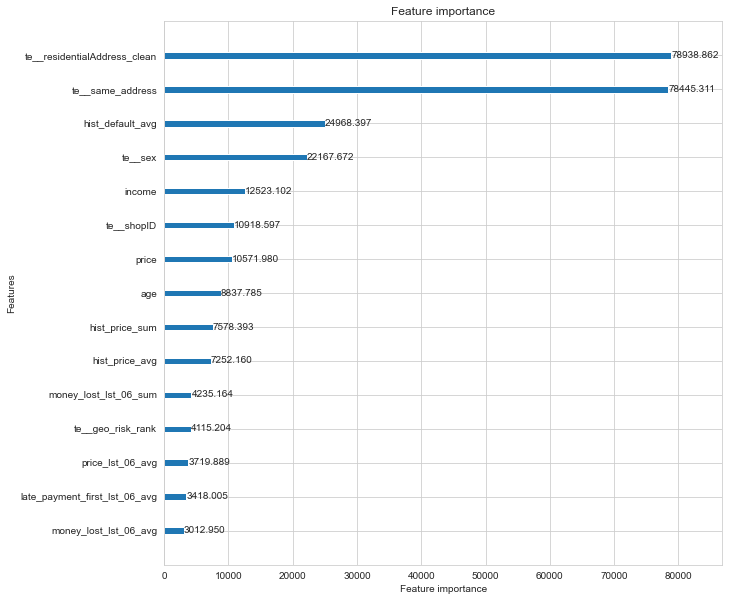

In [114]:
model= lgb.train(lgb_params, d_train)
fig, ax2 = plt.subplots(figsize=(10,10))
lgb.plot_importance(model, max_num_features=15, ax=ax2, importance_type = 'gain')